In [ ]:
import shutil

# Move the kaggle.json file to the .kaggle folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content/brats20
!unzip -q /content/brats20/brats20-dataset-training-validation.zip -d /content/brats20


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0


In [ ]:
!kaggle datasets download -d zhangweiled/lidcidri -p /content/lidcidri
!unzip -q /content/lidcidri/lidcidri.zip -d /content/lidcidri


Dataset URL: https://www.kaggle.com/datasets/zhangweiled/lidcidri
License(s): copyright-authors


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import cv2
import glob
from skimage.metrics import structural_similarity as ssim

In [ ]:
class Config:
    batch_size = 32
    epochs = 100
    lr_d = 1e-4
    lr_g = 3e-4
    gp_weight = 10
    n_critic = 3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    latent_dim = 256
    img_size = 128
    anomaly_threshold = 0.4
    brats_path = "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    lidc_path = "/content/lidcidri/LIDC-IDRI-slices"


In [ ]:
# Data Loading Functions (as per your implementation)
def load_brats_slices(brats_root_dir, limit=1000):
    images = []
    count = 0

    for patient in os.listdir(brats_root_dir):
        if count >= limit:
            break

        patient_dir = os.path.join(brats_root_dir, patient)
        if not os.path.isdir(patient_dir):
            continue

        flair_file = None
        for file in os.listdir(patient_dir):
            if file.endswith("_flair.nii") or file.endswith("_flair.nii.gz"):
                flair_file = os.path.join(patient_dir, file)
                break

        if not flair_file or not os.path.exists(flair_file):
            continue

        try:
            flair_img = nib.load(flair_file).get_fdata()
            mid = flair_img.shape[2] // 2
            for i in range(mid - 10, mid + 10):
                slice_img = flair_img[:, :, i]
                slice_img = cv2.resize(slice_img, (128, 128))
                slice_img = np.clip(slice_img, 0, 255).astype(np.uint8)
                slice_img = np.expand_dims(slice_img, -1)
                images.append(slice_img)
                count += 1
                if count >= limit:
                    break
        except Exception as e:
            print(f"Failed to process {flair_file}: {e}")

    return np.array(images)

In [ ]:
def load_lidc_images(root_dir, limit=1000):
    image_paths = glob.glob(os.path.join(root_dir, "**", "**", "images", "*.png"), recursive=True)
    images = []

    for path in image_paths[:limit]:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = np.expand_dims(img, axis=-1)
            images.append(img)

    return np.array(images)

In [ ]:
def preprocess_imgs(imgs):
    imgs = np.array(imgs).astype(np.float32) / 255.0
    imgs = (imgs - 0.5) * 2  # normalize to [-1, 1]
    imgs = np.transpose(imgs, (0, 3, 1, 2))  # Rearrange to (N, 1, 128, 128)
    return torch.tensor(imgs)

In [ ]:
# Load and prepare data
brats_imgs = preprocess_imgs(load_brats_slices(Config.brats_path, limit=1000))
lidc_imgs = preprocess_imgs(load_lidc_images(Config.lidc_path, limit=1000))
all_imgs = torch.cat([lidc_imgs, brats_imgs], dim=0)

# Create DataLoader
dataset = TensorDataset(all_imgs, torch.zeros(len(all_imgs)))
data_loader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

Epoch [1/100] Batch [0/63]
D Loss: 2331.6045 | G Loss: 0.1559
Macro Scores - Real: -0.15 Fake: -0.09
Micro Scores - Real: -0.03 Fake: -0.06

Epoch [1/100] Batch [50/63]
D Loss: 0.4801 | G Loss: -2.3646
Macro Scores - Real: 5.05 Fake: 2.90
Micro Scores - Real: 0.04 Fake: -0.14

Epoch [2/100] Batch [0/63]
D Loss: -5.7767 | G Loss: -1.6693
Macro Scores - Real: 8.48 Fake: 1.87
Micro Scores - Real: 0.14 Fake: -0.21

Epoch [2/100] Batch [50/63]
D Loss: -7.2452 | G Loss: -1.7791
Macro Scores - Real: 11.28 Fake: 2.78
Micro Scores - Real: 0.10 Fake: -0.16

Epoch [3/100] Batch [0/63]
D Loss: -7.1537 | G Loss: -3.4166
Macro Scores - Real: 12.38 Fake: 3.59
Micro Scores - Real: 0.14 Fake: -0.19

Epoch [3/100] Batch [50/63]
D Loss: -0.0101 | G Loss: -9.1810
Macro Scores - Real: 11.79 Fake: 10.30
Micro Scores - Real: 0.17 Fake: -0.16

Epoch [4/100] Batch [0/63]
D Loss: -0.5312 | G Loss: -9.6908
Macro Scores - Real: 11.19 Fake: 9.91
Micro Scores - Real: 0.13 Fake: -0.21

Epoch [4/100] Batch [50/63]
D 

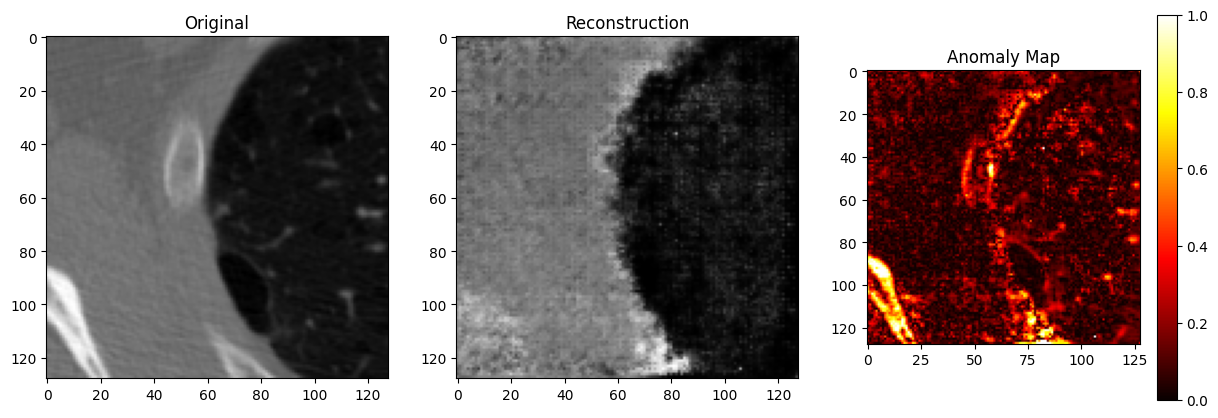

In [ ]:
# Fixed Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 256x1x1
            nn.ConvTranspose2d(256, 512, 4, 1, 0, bias=False),  # Output: 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # Output: 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),    # Output: 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),     # Output: 128x128
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x.view(-1, 256, 1, 1))

class MacroDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 32, 8, 4, 2)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(32, 64, 4, 2, 1)),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(128, 1, 4, 1, 0))
        )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=0.5)
        return self.main(x).view(-1)

class MicroDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 128, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 0))
        )

    def forward(self, x):
        return self.main(x).view(-1)

class WGANTrainer:
    def __init__(self):
        self.G = Generator().to(Config.device)
        self.D_macro = MacroDiscriminator().to(Config.device)
        self.D_micro = MicroDiscriminator().to(Config.device)

        self.optim_G = optim.Adam(self.G.parameters(), lr=Config.lr_g, betas=(0.5, 0.9))
        self.optim_D = optim.Adam(
            list(self.D_macro.parameters()) + list(self.D_micro.parameters()),
            lr=Config.lr_d,
            betas=(0.5, 0.9)
        )

        self.loader = DataLoader(TensorDataset(all_imgs),
                               batch_size=Config.batch_size,
                               shuffle=True,
                               pin_memory=True)

    def gradient_penalty(self, D, real, fake):
        alpha = torch.rand(real.size(0), 1, 1, 1, device=Config.device)
        interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        d_interpolates = D(interpolates)

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def train(self):
        for epoch in range(Config.epochs):
            for i, (real_imgs,) in enumerate(self.loader):
                real_imgs = real_imgs.to(Config.device)
                batch_size = real_imgs.size(0)

                # Train Discriminators
                self.optim_D.zero_grad()

                # Real images
                real_loss_macro = -torch.mean(self.D_macro(real_imgs))
                real_loss_micro = -torch.mean(self.D_micro(real_imgs))

                # Fake images
                noise = torch.randn(batch_size, Config.latent_dim, device=Config.device)
                with torch.no_grad():
                    fake_imgs = self.G(noise)

                fake_loss_macro = torch.mean(self.D_macro(fake_imgs))
                fake_loss_micro = torch.mean(self.D_micro(fake_imgs))

                # Gradient penalties
                gp_macro = self.gradient_penalty(self.D_macro, real_imgs.data, fake_imgs.data)
                gp_micro = self.gradient_penalty(self.D_micro, real_imgs.data, fake_imgs.data)

                d_loss = (real_loss_macro + real_loss_micro +
                         fake_loss_macro + fake_loss_micro +
                         Config.gp_weight * (gp_macro + gp_micro))

                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D_macro.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(self.D_micro.parameters(), 1.0)
                self.optim_D.step()

                # Train Generator
                if i % Config.n_critic == 0:
                    self.optim_G.zero_grad()
                    gen_imgs = self.G(noise)
                    g_loss = (-torch.mean(self.D_macro(gen_imgs)) +
                             -torch.mean(self.D_micro(gen_imgs)))
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.G.parameters(), 0.5)
                    self.optim_G.step()

                # Logging
                if i % 50 == 0:
                    with torch.no_grad():
                        real_macro = torch.mean(self.D_macro(real_imgs)).item()
                        real_micro = torch.mean(self.D_micro(real_imgs)).item()
                        fake_macro = torch.mean(self.D_macro(fake_imgs)).item()
                        fake_micro = torch.mean(self.D_micro(fake_imgs)).item()

                    print(f"Epoch [{epoch+1}/{Config.epochs}] Batch [{i}/{len(self.loader)}]")
                    print(f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
                    print(f"Macro Scores - Real: {real_macro:.2f} Fake: {fake_macro:.2f}")
                    print(f"Micro Scores - Real: {real_micro:.2f} Fake: {fake_micro:.2f}\n")

# Enhanced Anomaly Detector
class AnomalyDetector:
    def __init__(self, generator):
        self.G = generator.eval()

    def detect(self, image, steps=200):
        image = image.to(Config.device).unsqueeze(0)
        z = torch.randn(1, Config.latent_dim, requires_grad=True, device=Config.device)
        optimizer = optim.Adam([z], lr=0.01)

        for _ in range(steps):
            recon = self.G(z)
            loss = (image - recon).pow(2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        diff = (image - recon).abs().squeeze().cpu().detach().numpy()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
        plt.title("Original")

        plt.subplot(1, 3, 2)
        plt.imshow(recon.squeeze().detach().cpu().numpy(), cmap='gray')
        plt.title("Reconstruction")

        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot', vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Anomaly Map")
        plt.show()

# Training Execution
trainer = WGANTrainer()
trainer.train()

# Anomaly Detection Example (using your dataset)
sample_img = all_imgs[0].unsqueeze(0).to(Config.device)
detector = AnomalyDetector(trainer.G)
detector.detect(sample_img)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

def evaluate_anomaly_detector(detector, test_images, test_labels, threshold=0.4):
    all_scores = []
    all_ssim = []
    recon_errors = []

    for i, img in enumerate(test_images):
        img_tensor = img.unsqueeze(0).to(Config.device)
        z = torch.randn(1, Config.latent_dim, requires_grad=True, device=Config.device)
        optimizer = optim.Adam([z], lr=0.01)

        for _ in range(200):  # optimize latent vector
            recon = detector.G(z)
            loss = (img_tensor - recon).pow(2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        recon_np = recon.squeeze().detach().cpu().numpy()
        original_np = img_tensor.squeeze().detach().cpu().numpy()
        mse = np.mean((original_np - recon_np) ** 2)
        ssim_score = ssim(original_np, recon_np, data_range=2.0)

        score = mse  # or (1 - ssim_score), or weighted combo
        all_scores.append(score)
        recon_errors.append(mse)
        all_ssim.append(ssim_score)

    # ROC AUC
    roc_auc = roc_auc_score(test_labels, all_scores)
    preds = [1 if score > threshold else 0 for score in all_scores]
    acc = accuracy_score(test_labels, preds)

    print(f"\n--- Evaluation Report ---")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy (Threshold={threshold}): {acc:.4f}")
    print(f"Average MSE: {np.mean(recon_errors):.6f}")
    print(f"Average SSIM: {np.mean(all_ssim):.6f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Anomaly Detection")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



--- Evaluation Report ---
ROC AUC: 0.6606
Accuracy (Threshold=0.4): 0.5975
Average MSE: 0.113581
Average SSIM: 0.404877


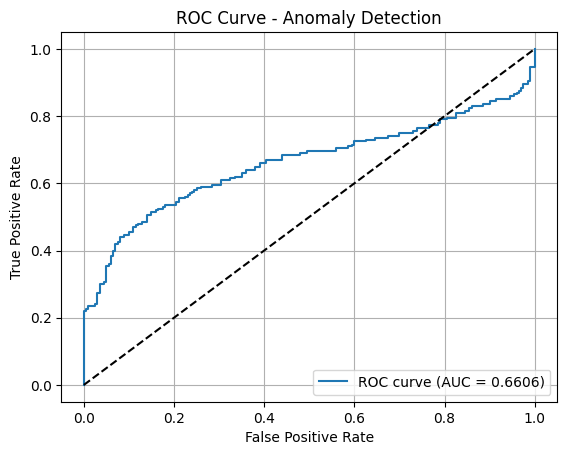

In [ ]:
# Select test samples
num_test_samples = 200
lidc_test = lidc_imgs[:num_test_samples]
brats_test = brats_imgs[:num_test_samples]

# Combine and create labels
test_images = torch.cat([lidc_test, brats_test], dim=0)
test_labels = np.array([0]*num_test_samples + [1]*num_test_samples)

# Instantiate the trained generator
detector = AnomalyDetector(trainer.G)

# Evaluate
evaluate_anomaly_detector(detector, test_images, test_labels, threshold=Config.anomaly_threshold)
